In [1]:
#!/usr/bin/env python

'''
DESCRIPTION
-----------
    To export pathway order
    
RETURN
------
    {}. :  file
        
        
EXPORTED FILE(s) LOCATION
-------------------------
    .//{}/{EXPERIMENT}/{}.
'''

# importing default libraries
# import os, argparse, sys
# sys.path.append('./')
import os, sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)

In [2]:
# importing scripts in scripts folder
from scripts import settings as srp
# importing default libraries
import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

# from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, LeaveOneGroupOut
from sklearn.preprocessing import OneHotEncoder

# import tensorflow as tf
# from tensorflow import keras
from numba import cuda

# DEFAULT VALUES for PAPER DESIGN
# epochs_default=100
# batch_default=10
# val_split=0.1

rand_state = 91
# shuffle_=True
# test_size = 0.3 # train_test_split
# kf_split = 5 # KFold

time_start = dt.datetime.now().time().strftime('%H:%M:%S') # = time.time() dt.datetime.now().strftime('%Y%m%d_%I%M%S%p')

scripts/settings.py - PATHS IMPORTED!!!


In [3]:
# # giving the model path
# model_path = '../data/output/result_NN/models/signaling_log1p/design_a1_signaling.h5'

dataset              = 'exper_immune_raw_sw_log1p.pck'
bio_knowledge        = 'pbk_layer_hsa.txt'
experiment           = 'exper_immune'
analysis             = 'activation'
# defining biological knowledge layer based on the architecture of required model
bio_layer_number     = 1

# the output location
loc_output = os.path.join(srp.DIR_REPORTS, analysis, experiment)
srp.define_folder(loc_=loc_output)

'./reports/activation/exper_immune/'

In [4]:
i_design ='a1'
model, model_pbk = srp.loading_model('./models/NN/exper_immune/model_'+i_design+'_'+dataset.split('.')[0]+'_train_test_split.h5', bio_layer_number)
model_pbk.summary()

Loaded model!! ./models/NN/exper_immune/model_a1_exper_immune_raw_sw_log1p_train_test_split.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    [(None, 2089)]            0         
_________________________________________________________________
layer1 (Dense)               (None, 93)                194370    
Total params: 194,370
Trainable params: 194,370
Non-trainable params: 0
_________________________________________________________________


In [5]:
print('FILE FORMAT, ', dataset.split('.')[1])

if dataset.split('.')[1]=='pck':
    df_raw = pd.read_pickle(os.path.join(srp.DIR_DATA_PROCESSED, experiment, dataset))
    df_raw = pd.concat([(df_raw.iloc[:, :-1]).astype(float) ,df_raw.iloc[:, -1]], axis=1)
else:
    df_raw = pd.read_csv(os.path.join(srp.DIR_DATA_PROCESSED, experiment, dataset))

sort_genes = sorted(df_raw.columns[:-1])
sort_genes.extend(df_raw.columns[-1:])
df_raw = df_raw[sort_genes]

# Importing all prior biological knowledge and combine all genes to create a common gene list
list_gene = None
if (bio_knowledge!=None):
    df_bio = pd.DataFrame(pd.read_csv(os.path.join(srp.DIR_DATA_PROCESSED, bio_knowledge), index_col=0)).sort_index()
    df_bio_filtered = df_bio.iloc[df_bio.index.isin(df_raw.columns), :]
    

print('Dataset cell type, ', df_raw.groupby('cell_type').size())
print('\nDataset shape             , ', df_raw.shape)
print('Biological knowledge shape, ', df_bio_filtered.shape)

print('\nDataset gene order top 10              ,', list(df_raw.columns[:10]))
print('Biological knowledge gene order top 10, ', list(df_bio_filtered.index[:10].values))

FILE FORMAT,  pck
Dataset cell type,  cell_type
DC              957
ILC             574
NK               74
Tcell         23484
macrophage      503
mixed            12
dtype: int64

Dataset shape             ,  (25604, 2090)
Biological knowledge shape,  (2089, 93)

Dataset gene order top 10              , ['a2m', 'abcb4', 'abcc2', 'abhd5', 'abi2', 'abl1', 'abl2', 'ablim1', 'ablim3', 'acaa1']
Biological knowledge gene order top 10,  ['a2m', 'abcb4', 'abcc2', 'abhd5', 'abi2', 'abl1', 'abl2', 'ablim1', 'ablim3', 'acaa1']


In [6]:
ohe = OneHotEncoder()
X = df_raw.iloc[:, :-1].values
y = df_raw.iloc[:, -1:].values
y_ohe = ohe.fit_transform(y).toarray()
# groups = y.reshape(1,-1)[0]

print(X.shape)
print(y.shape)
# print(groups.shape)

(25604, 2089)
(25604, 1)


In [7]:
y_pred = model_pbk.predict(X)
# creating dataframe which stores both prediction label of model and 'encode' information of given layer
df_activation_pred = pd.concat([pd.DataFrame(y_pred, columns=df_bio_filtered.columns)
                                , pd.DataFrame([ohe.categories_[0][i] for i in np.argmax(model.predict(X), axis=-1)],  columns=['cell_type']) ]
                              , axis=1)
df_activation_pred

,hsa03320,hsa04010,hsa04012,hsa04014,hsa04015,hsa04020,hsa04022,hsa04024,hsa04062,hsa04064,...,hsa04960,hsa04961,hsa04962,hsa04970,hsa04971,hsa04972,hsa04973,hsa04976,hsa05100,cell_type
0,0.0,0.0,0.0,0.0,21.926126,0.0,37.928154,21.261353,0.0,0.0,...,0.0,0.0,41.604160,0.0,0.000000,0.0,0.0,0.0,34.467873,Tcell
1,0.0,0.0,0.0,0.0,16.221735,0.0,23.260378,9.434815,0.0,0.0,...,0.0,0.0,20.555677,0.0,0.000000,0.0,0.0,0.0,19.106632,Tcell
2,0.0,0.0,0.0,0.0,20.108873,0.0,25.527639,12.490024,0.0,0.0,...,0.0,0.0,20.261705,0.0,1.512120,0.0,0.0,0.0,22.356150,Tcell
3,0.0,0.0,0.0,0.0,14.949991,0.0,22.707310,10.332338,0.0,0.0,...,0.0,0.0,18.884274,0.0,0.000000,0.0,0.0,0.0,16.187355,Tcell
4,0.0,0.0,0.0,0.0,15.813116,0.0,27.832647,11.882807,0.0,0.0,...,0.0,0.0,21.106775,0.0,0.000000,0.0,0.0,0.0,20.265799,Tcell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25599,0.0,0.0,0.0,0.0,3.443304,0.0,8.525702,0.000000,0.0,0.0,...,0.0,0.0,0.772772,0.0,34.277023,0.0,0.0,0.0,0.000000,NK
25600,0.0,0.0,0.0,0.0,12.385365,0.0,14.830104,0.000000,0.0,0.0,...,0.0,0.0,4.459647,0.0,27.324389,0.0,0.0,0.0,0.000000,NK
25601,0.0,0.0,0.0,0.0,8.863573,0.0,23.392096,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,26.992579,0.0,0.0,0.0,0.000000,NK
25602,0.0,0.0,0.0,0.0,3.042610,0.0,10.739582,0.000000,0.0,0.0,...,0.0,0.0,0.333202,0.0,21.652557,0.0,0.0,0.0,0.000000,NK


In [8]:
# finding non-active pathways (according to std values)
pathway_std_less_than_one = df_activation_pred.groupby('cell_type').std().sum()[df_activation_pred.groupby('cell_type').std().sum()<1].index
# printing information about non-active nodes
print('The number of non-active nodes is ', len(pathway_std_less_than_one))
print('The non-active nodes are; ')
print(pathway_std_less_than_one)

The number of non-active nodes is  72
The non-active nodes are; 
Index(['hsa04010', 'hsa04012', 'hsa04014', 'hsa04020', 'hsa04062', 'hsa04064',
       'hsa04066', 'hsa04068', 'hsa04071', 'hsa04072', 'hsa04110', 'hsa04114',
       'hsa04115', 'hsa04150', 'hsa04151', 'hsa04152', 'hsa04210', 'hsa04211',
       'hsa04218', 'hsa04261', 'hsa04270', 'hsa04310', 'hsa04330', 'hsa04340',
       'hsa04350', 'hsa04360', 'hsa04370', 'hsa04380', 'hsa04390', 'hsa04510',
       'hsa04520', 'hsa04530', 'hsa04540', 'hsa04610', 'hsa04611', 'hsa04612',
       'hsa04620', 'hsa04621', 'hsa04622', 'hsa04623', 'hsa04650', 'hsa04660',
       'hsa04662', 'hsa04664', 'hsa04666', 'hsa04668', 'hsa04670', 'hsa04723',
       'hsa04724', 'hsa04727', 'hsa04728', 'hsa04740', 'hsa04742', 'hsa04750',
       'hsa04810', 'hsa04910', 'hsa04911', 'hsa04912', 'hsa04913', 'hsa04914',
       'hsa04915', 'hsa04916', 'hsa04917', 'hsa04918', 'hsa04920', 'hsa04922',
       'hsa04960', 'hsa04961', 'hsa04970', 'hsa04972', 'hsa04973',

In [9]:
# export activation scores of each pathways for each sample
df_active = df_activation_pred.iloc[:, ~df_activation_pred.columns.isin(pathway_std_less_than_one)]
df_active.to_csv(os.path.join(loc_output+'activation_score.csv'))
df_active

,hsa03320,hsa04015,hsa04022,hsa04024,hsa04213,hsa04550,hsa04630,hsa04710,hsa04713,hsa04720,...,hsa04726,hsa04919,hsa04921,hsa04923,hsa04924,hsa04925,hsa04962,hsa04971,hsa05100,cell_type
0,0.0,21.926126,37.928154,21.261353,51.820179,0.0,0.0,9.600803,0.0,5.264059,...,0.000000,2.982046,0.0,0.000000,0.0,0.00000,41.604160,0.000000,34.467873,Tcell
1,0.0,16.221735,23.260378,9.434815,28.478117,0.0,0.0,0.000000,0.0,2.112776,...,0.000000,2.727366,0.0,0.000000,0.0,0.00000,20.555677,0.000000,19.106632,Tcell
2,0.0,20.108873,25.527639,12.490024,28.744663,0.0,0.0,1.443461,0.0,3.242292,...,0.000000,10.458461,0.0,0.000000,0.0,1.12999,20.261705,1.512120,22.356150,Tcell
3,0.0,14.949991,22.707310,10.332338,26.638388,0.0,0.0,0.000000,0.0,2.038768,...,0.000000,2.218566,0.0,2.982447,0.0,0.00000,18.884274,0.000000,16.187355,Tcell
4,0.0,15.813116,27.832647,11.882807,30.532667,0.0,0.0,2.830913,0.0,5.889569,...,0.000000,3.736261,0.0,0.240788,0.0,0.00000,21.106775,0.000000,20.265799,Tcell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25599,0.0,3.443304,8.525702,0.000000,17.488230,0.0,0.0,2.628990,0.0,0.000000,...,0.000000,34.536537,0.0,0.000000,0.0,0.00000,0.772772,34.277023,0.000000,NK
25600,0.0,12.385365,14.830104,0.000000,28.524248,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,38.457287,0.0,0.000000,0.0,0.00000,4.459647,27.324389,0.000000,NK
25601,0.0,8.863573,23.392096,0.000000,27.809061,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,29.184505,0.0,0.000000,0.0,0.00000,0.000000,26.992579,0.000000,NK
25602,0.0,3.042610,10.739582,0.000000,11.228155,0.0,0.0,0.000000,0.0,0.000000,...,2.900617,21.798586,0.0,0.000000,0.0,0.00000,0.333202,21.652557,0.000000,NK


## PLOT DISTRIBUTION of PATHWAYS ACTIVITIES

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

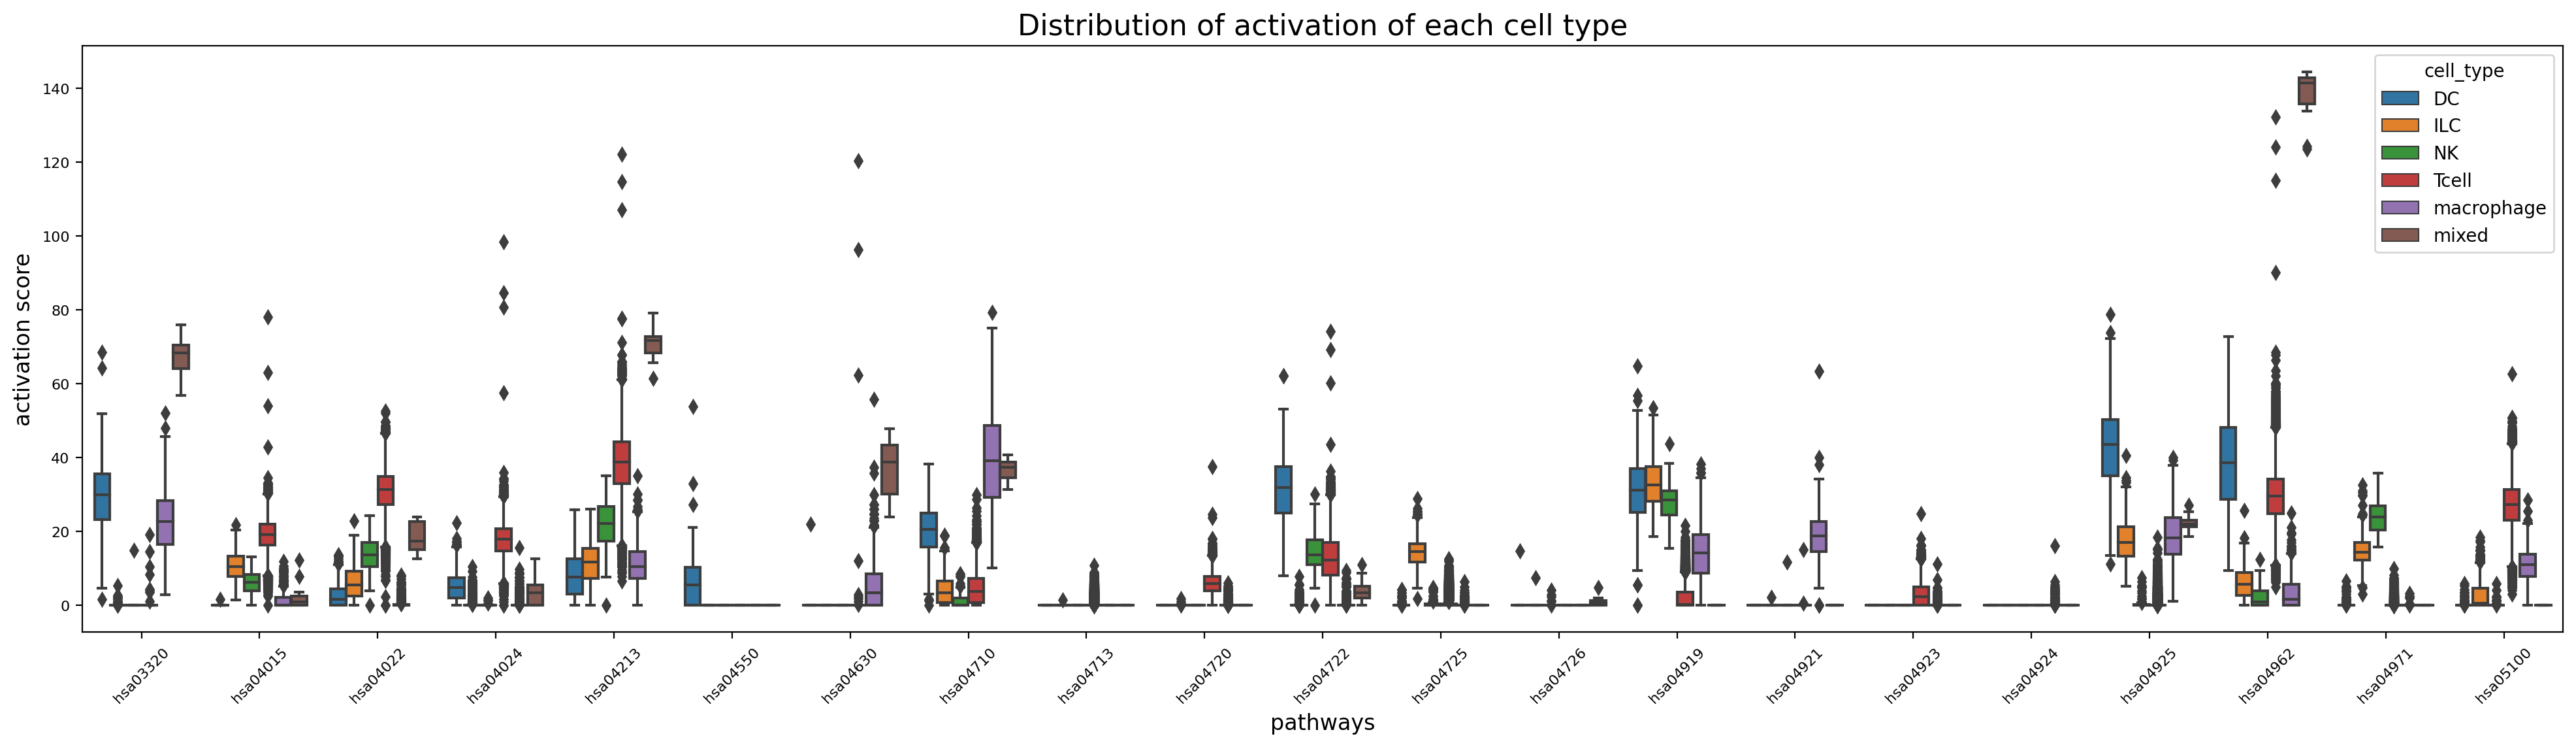

In [14]:
# to visualize the distribution for each pathway, pd.melt operation applied into df_plot dataset
# visualization of the activities of all pathway according to cell_type
order_train = sorted(list(set(df_raw['cell_type'].values)))
plt.figure(figsize=(20,6), dpi=200)
sns.boxplot(x='variable', y='value', data=pd.melt(df_active, id_vars='cell_type'), hue='cell_type', hue_order=dict(zip(order_train, range(len(order_train)))))
plt.xticks(rotation=45);
plt.title('Distribution of activation of each cell type')
plt.xlabel('pathways')
plt.ylabel('activation score')
plt.tight_layout()
# exporting the graph
# plt.savefig(os.path.join(path_output, 'distribution_activities_full.png'))